<a href="https://colab.research.google.com/github/tavaresRamon/redesNeurais/blob/main/LSTMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as stats

In [24]:
# Carregando arquivos
uploadArquivos = files.upload()

Saving dadosMensais.csv to dadosMensais (1).csv


In [25]:
# Arquivando meus dados em uma lista
meusDados = list(uploadArquivos.keys())[0]
dados0 = pd.read_csv(meusDados)

In [ ]:
dados0

In [28]:

dados = dados0[['ano','mes','amg_RX1Day']]


In [29]:
# Dicionário para mapear nomes de meses para números de 1 a 12
meses = {
    'jan': '01',
    'fev': '02',
    'mar': '03',
    'abr': '04',
    'mai': '05',
    'jun': '06',
    'jul': '07',
    'ago': '08',
    'set': '09',
    'out': '10',
    'nov': '11',
    'dez': '12'
}

In [ ]:
dados['data_completa'] = dados['ano'].astype(str) + '-' +dados['mes'].map(meses)
dados = dados[dados['mes'] != 'anual']
dados['data_completa'] = pd.to_datetime(dados['data_completa'])

In [31]:
dados

,ano,mes,amg_RX1Day,data_completa
0,1950,jan,17.1,1950-01-01
1,1950,fev,13.7,1950-02-01
2,1950,mar,21.8,1950-03-01
3,1950,abr,22.3,1950-04-01
4,1950,mai,10.2,1950-05-01
...,...,...,...,...
709,2004,ago,3.8,2004-08-01
710,2004,set,5.2,2004-09-01
711,2004,out,20.1,2004-10-01
712,2004,nov,18.6,2004-11-01


In [32]:
# Definindo as datas em índices
dados.set_index('data_completa', inplace=True)

In [33]:
# Realizando a decomposição sazonal
decomposicaoSazonal = stats.tsa.seasonal_decompose(dados['amg_RX1Day'],model='additive')
sazonalidade = decomposicaoSazonal.seasonal
residuos = decomposicaoSazonal.resid
tendencia = decomposicaoSazonal.trend

# Criando variáveis da decomposição sazonal
dados['sazonalidade'] = sazonalidade
dados['tendencia'] = sazonalidade
dados['residuos'] = sazonalidade

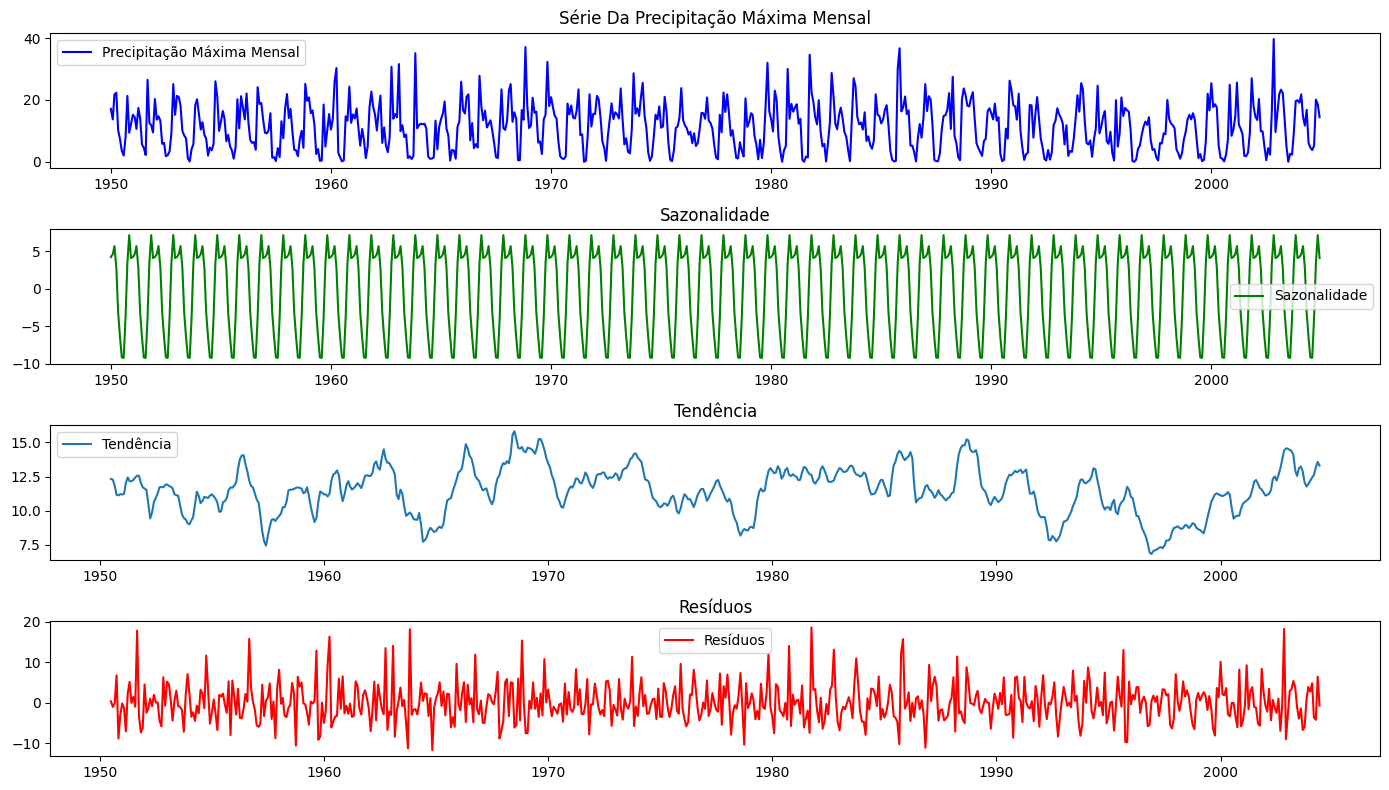

In [34]:
# Defina o tamanho dos gráficos
plt.figure(figsize=(14, 8))


# Gráfico 1: Série Temporal Original
plt.subplot(4, 1, 1)
plt.plot(dados['amg_RX1Day'], label='Precipitação Máxima Mensal', color="blue")
plt.title('Série Da Precipitação Máxima Mensal')
plt.legend()

# Gráfico 1: Série Temporal Original
plt.subplot(4, 1, 2)
plt.plot(sazonalidade, label='Sazonalidade', color="green")
plt.title('Sazonalidade')
plt.legend()

# Gráfico 2: Tendência
plt.subplot(4, 1, 3)
plt.plot(tendencia, label='Tendência')
plt.title('Tendência')
plt.legend()

# Gráfico 3: Resíduos
plt.subplot(4, 1, 4)
plt.plot(residuos, label='Resíduos',color="red")
plt.title('Resíduos')
plt.legend()

# Ajuste o espaçamento entre os gráficos
plt.tight_layout()
plt.show()


In [35]:
# Teste ADF Hipótese nula: Série não é estacionária
resultadoAdf = stats.tsa.adfuller(dados['amg_RX1Day'])
valorAdf = resultadoAdf[1]

if valorAdf < 0.05:
    print("A série é estacionária (hipótese nula rejeitada).")
else:
    print("A série não é estacionária (hipótese nula não rejeitada).")


A série é estacionária (hipótese nula rejeitada).


In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# # Normalização dos dados
# scaler = MinMaxScaler()
# dados['amg_RX1Day'] = scaler.fit_transform(dados['amg_RX1Day'].values.reshape(-1, 1))

In [36]:
# Preparando os dados para a LSTM
def prepareDados(dados, periodo):
  x, y = [], []
  for i in range(len(dados) - periodo):
    x.append(dados[i:i+periodo])
    y.append(dados[i+periodo])
  return np.array(x), np.array(y)
lags = 12
var = 1
x,y = prepareDados(dados['amg_RX1Day'],lags)

In [37]:
# Divisão dos dados em treino e teste
treino = int(0.7 * len(x))
teste = int(0.2 * len(x))

In [38]:
# Construção dos dados em treinamento, validação e teste
xTreino, yTreino = x[:treino], y[:treino]
xValidacao, yValidacao = x[treino:(treino+teste)], y[treino:(treino+teste)]
xTeste, yTeste = x[treino+teste:], y[treino+teste:]
xTreino.shape,yTreino.shape, xValidacao.shape,yValidacao.shape,xTeste.shape,yTeste.shape


((453, 12), (453,), (129, 12), (129,), (66, 12), (66,))

In [58]:
from keras.src.layers.rnn.lstm_v1 import LSTM
from keras.src.engine.input_layer import InputLayer
from sklearn.preprocessing import MinMaxScaler
from keras.layers import *
from keras.models import Sequential
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
# Cria um modelo sequencial
modelo = Sequential()
modelo.add(InputLayer((lags, var)))
modelo.add(LSTM(128, return_sequences=True))
modelo.add(Dropout(0.1))
modelo.add(BatchNormalization())
modelo.add(LSTM(128, return_sequences=False))
modelo.add(Dropout(0.1))
modelo.add(BatchNormalization())
modelo.add(Dense(128, activation='relu'))
modelo.add(Dense(1, activation='linear'))
modelo.summary()
#Este modelo está configurado para capturar padrões em dados sequenciais,
#como séries temporais, enquanto aplica técnicas de regularização e normalização para melhorar o treinamento e a generalização.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 12, 128)           66560     
                                                                 
 dropout_8 (Dropout)         (None, 12, 128)           0         
                                                                 
 batch_normalization_10 (Ba  (None, 12, 128)           512       
 tchNormalization)                                               
                                                                 
 lstm_11 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_11 (Ba  (None, 128)               512       
 tchNormalization)                                    

In [59]:
checkPoint = ModelCheckpoint('modelo/', save_best_only=True)
modelo.compile(loss=MeanSquaredError(),
               optimizer=Adam(learning_rate=0.001),
               metrics=[RootMeanSquaredError()])

In [ ]:
from keras.src import callbacks
modelo.fit(xTreino, yTreino,
           validation_data=(xValidacao, yValidacao),
           epochs=100, callbacks=[checkPoint])

In [61]:
from keras.models import load_model
modelo = load_model('modelo/')

In [62]:
from sklearn.metrics import mean_squared_error as mse
def plotarPredicoes(modelo, x, y):
  predicoes = modelo.predict(x).flatten()
  dados = pd.DataFrame(data={'Reais':y, 'Preditos':predicoes})
  plt.figure(figsize=(10, 4))
  plt.plot(dados['Reais'],label='Reais',color="blue")
  plt.plot(dados['Preditos'],label='Preditos',color="red")
  plt.legend()
  plt.tight_layout()
  return dados, mse(y, predicoes)


3/3 [==============================] - 0s 17ms/step


(    Reais   Preditos
 0     2.5   3.416886
 1     0.2   2.896420
 2     0.6   3.508435
 3     6.5   8.988647
 4    22.0  14.301571
 ..    ...        ...
 61    3.8   3.446725
 62    5.2   2.722203
 63   20.1  12.610663
 64   18.6  19.688698
 65   14.4  16.861765
 
 [66 rows x 2 columns],
 28.485158328272504)

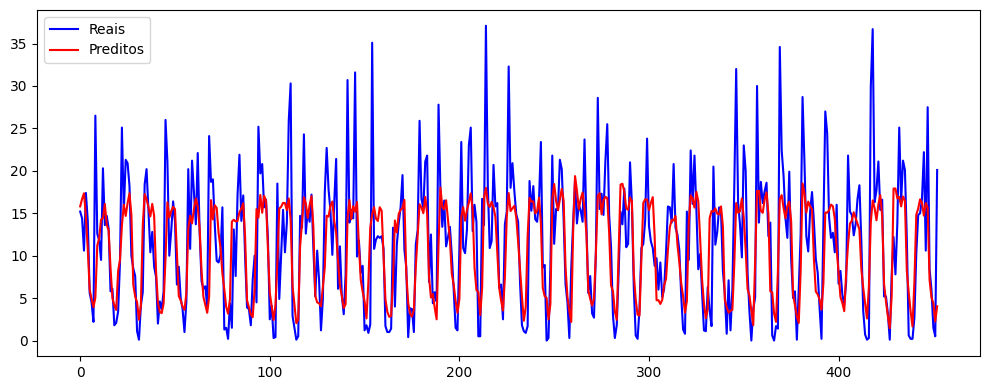

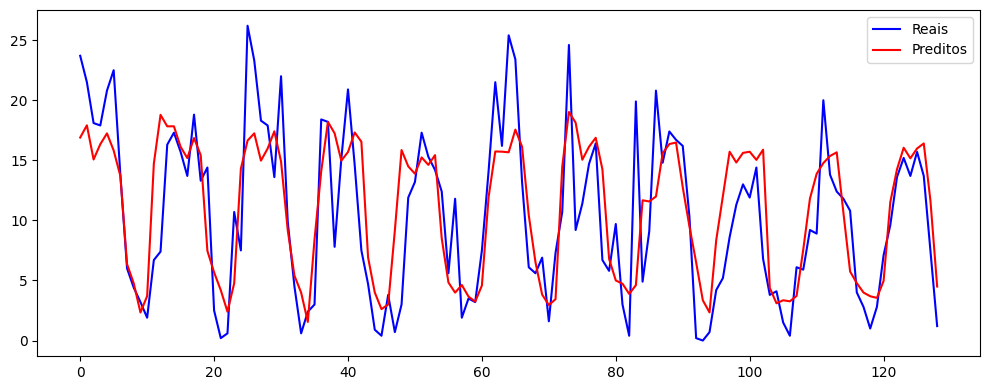

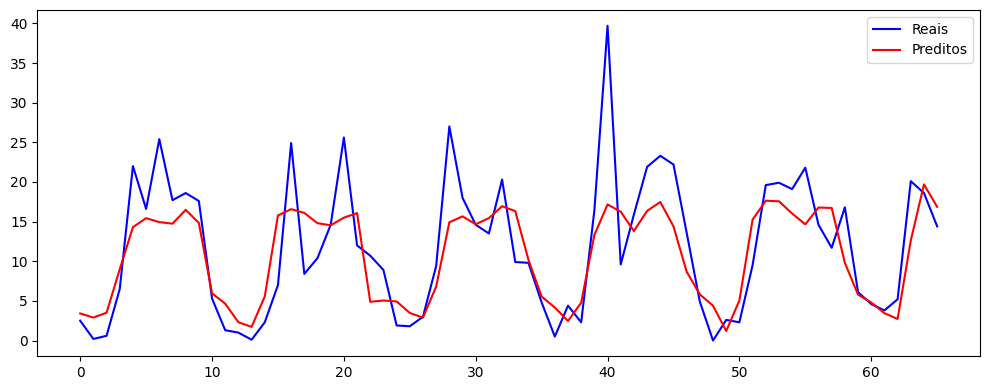

In [63]:
plotarPredicoes(modelo, xTreino, yTreino)
plotarPredicoes(modelo, xValidacao, yValidacao)
plotarPredicoes(modelo, xTeste, yTeste)

In [95]:
from keras.regularizers import l2

modelo2 = Sequential()
# Camada Conv1D empilhada para capturar padrões complexos
modelo2.add(InputLayer(input_shape=(lags, var)))
# Adicione uma camada Conv1D com 128 filtros e tamanho de kernel 2
modelo2.add(Conv1D(256, kernel_size=2, activation='relu'))
modelo2.add(MaxPooling1D(pool_size=2))  # Adicione uma camada de pooling
modelo.add(Dropout(0.1))
# Transforme os mapas de características 1D em um vetor
modelo2.add(Flatten())
# Adicione uma camada densa com regularização L2
modelo2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
# Adicione uma camada densa de saída com ativação linear
modelo2.add(Dense(1, activation='linear'))
modelo2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 11, 256)           768       
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 5, 256)            0         
 g1D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_28 (Dense)            (None, 256)               327936    
                                                                 
 dense_29 (Dense)            (None, 1)                 257       
                                                                 
Total params: 328961 (1.25 MB)
Trainable params: 328961 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [96]:
checkPoint2 = ModelCheckpoint('modelo2/', save_best_only=True)
modelo2.compile(loss=MeanSquaredError(),
               optimizer=Adam(learning_rate=0.001),
               metrics=[RootMeanSquaredError()])

In [ ]:
modelo2.fit(xTreino, yTreino,
           validation_data=(xValidacao, yValidacao),
           epochs=100, callbacks=[checkPoint])

3/3 [==============================] - 0s 8ms/step


(    Reais   Preditos
 0     2.5   3.587627
 1     0.2   1.412629
 2     0.6   5.792530
 3     6.5  13.514647
 4    22.0  18.433348
 ..    ...        ...
 61    3.8  -0.515297
 62    5.2   5.313791
 63   20.1  15.095795
 64   18.6  17.767773
 65   14.4  15.879801
 
 [66 rows x 2 columns],
 34.47849068014639)

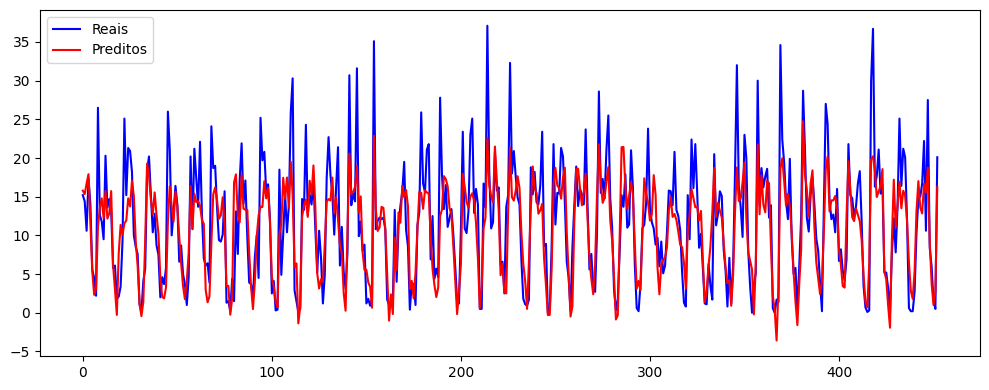

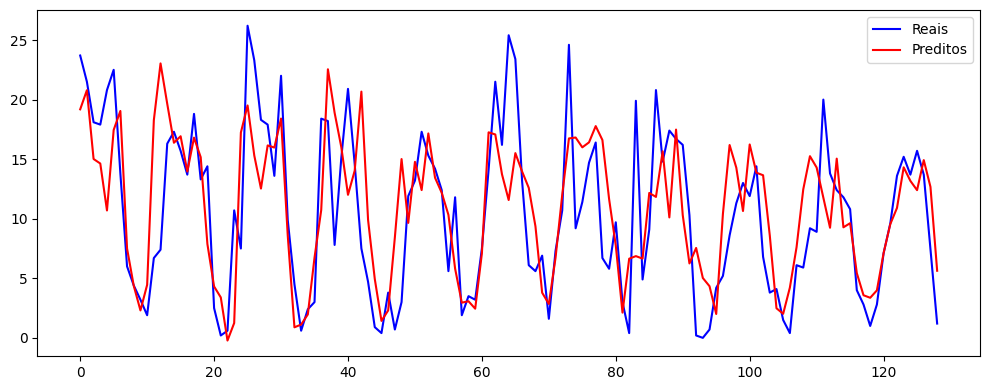

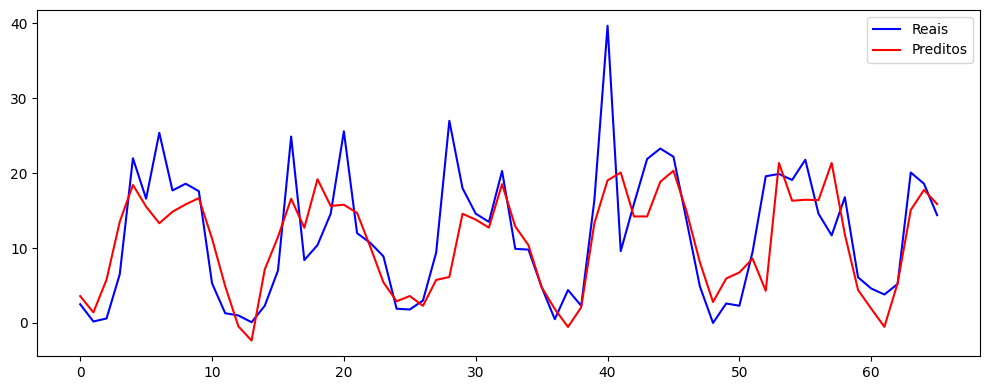

In [98]:
plotarPredicoes(modelo2, xTreino, yTreino)

plotarPredicoes(modelo2, xValidacao, yValidacao)

plotarPredicoes(modelo2, xTeste, yTeste)

In [74]:
modelo3 = Sequential()
# Camada GRU empilhada para capturar padrões complexos
modelo3.add(InputLayer((lags, var)))
modelo3.add(GRU(256))
# Aplique uma taxa de dropout para regularização
modelo3.add(Dropout(0.3))
modelo3.add(Dense(256, activation='relu'))
# Outra camada densa para a camada de saída
modelo3.add(Dense(1, activation='linear'))

modelo3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 256)               198912    
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 256)               65792     
                                                                 
 dense_19 (Dense)            (None, 1)                 257       
                                                                 
Total params: 264961 (1.01 MB)
Trainable params: 264961 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
checkPoint3 = ModelCheckpoint('modelo2/', save_best_only=True)
modelo3.compile(loss=MeanSquaredError(),
               optimizer=Adam(learning_rate=0.001),
               metrics=[RootMeanSquaredError()])

In [ ]:
modelo3.fit(xTreino, yTreino,
           validation_data=(xValidacao, yValidacao),
           epochs=100, callbacks=[checkPoint])

3/3 [==============================] - 0s 11ms/step


(    Reais   Preditos
 0     2.5   1.735403
 1     0.2   2.356057
 2     0.6   2.128264
 3     6.5  18.204275
 4    22.0  16.437778
 ..    ...        ...
 61    3.8   3.239248
 62    5.2   1.865072
 63   20.1  16.558798
 64   18.6  19.360216
 65   14.4  14.956731
 
 [66 rows x 2 columns],
 29.381416548927056)

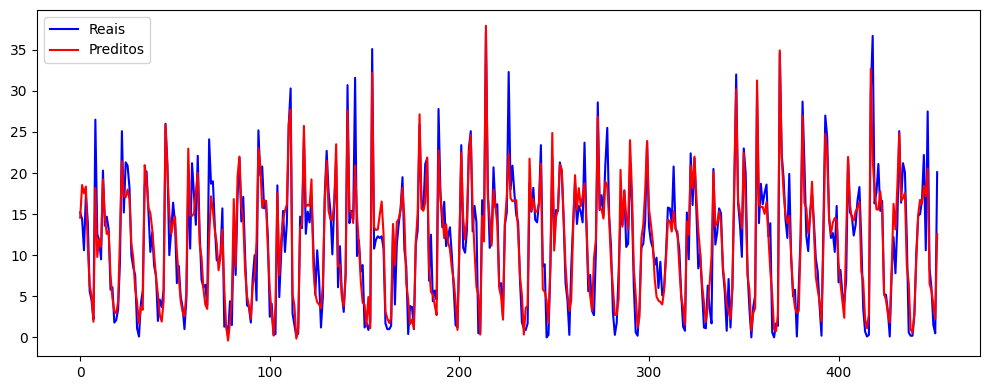

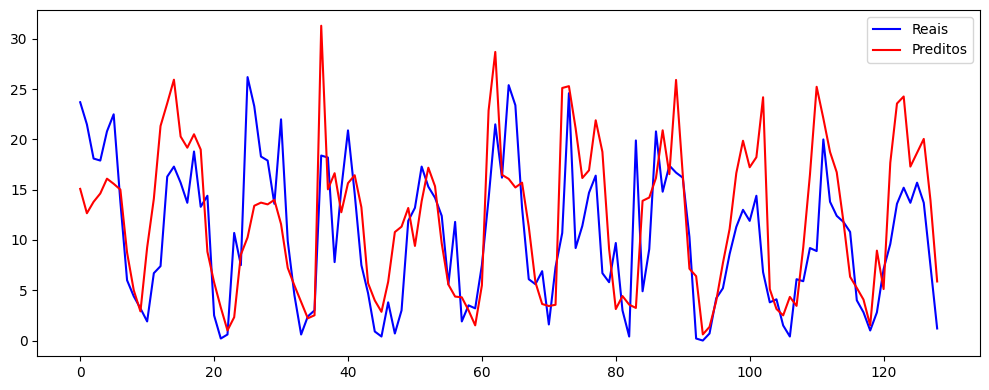

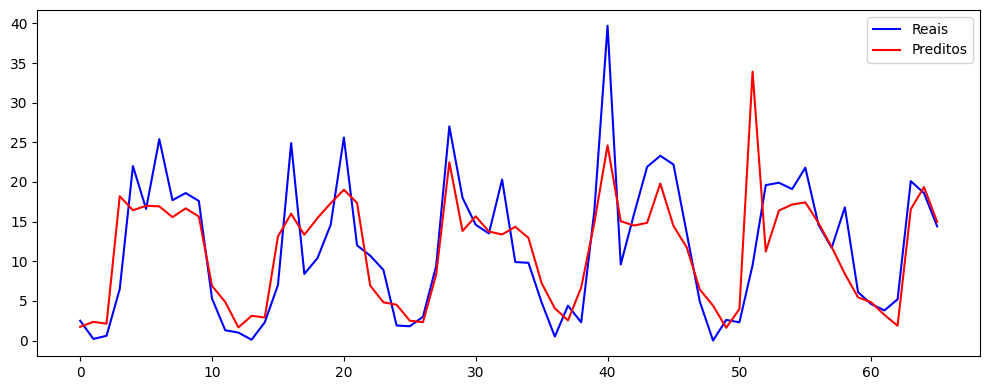

In [78]:
plotarPredicoes(modelo3, xTreino, yTreino)

plotarPredicoes(modelo3, xValidacao, yValidacao)

plotarPredicoes(modelo3, xTeste, yTeste)